The purpose of this notebook is to generate a plot to show the local ancestry breakdown of the CCLE cell lines

In [1]:
#Load packages
library(tidyverse)
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
#Load in the rfmix data
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.file.list = list.files(path = ".", pattern = ".Q")
rfmix.file.list

#Compile it all into a single object
rfmix.data = NULL #create an empty object to hold the data
index = 0 #define the for loop index
for(file in rfmix.file.list){
    index = index + 1 #increase the index
    
    
    #Load in and format the data
    individual.chromosome = read.table(file, fill = TRUE) %>%
    rename("sample" = 1, "African (AFR)" = 2, "American (AMR)" = 3, "East Asian (EAS)" = 4, "European (EUR)" = 5, "South Asian (SAS)" = 6) %>%
    select(-sample)
    
    
    
    #Add the data to the main data frame
    if(index == 1) {
        rfmix.data = individual.chromosome
    } else {
        rfmix.data = rfmix.data + individual.chromosome
    }
    
    
    
    #Divide the data by the number of chromosomes to get the ancestry fraction across the genome
    if(index == length(rfmix.file.list)) {
        rfmix.data = rfmix.data/length(rfmix.file.list)
    }
    
    
    
    #Re-add the sample names
    if(index == length(rfmix.file.list)){
        sample.names = read.table(file, fill = TRUE) %>%
        rename("sample" = 1) %>%
        pull(sample) 
        
    rfmix.data = rfmix.data %>%
        mutate(sample = sample.names, .before = "African (AFR)")
    }
    
}

head(rfmix.data)

[1] "chr1.rfmix.output.rfmix.Q"  "chr10.rfmix.output.rfmix.Q"
 [3] "chr11.rfmix.output.rfmix.Q" "chr12.rfmix.output.rfmix.Q"
 [5] "chr13.rfmix.output.rfmix.Q" "chr14.rfmix.output.rfmix.Q"
 [7] "chr15.rfmix.output.rfmix.Q" "chr16.rfmix.output.rfmix.Q"
 [9] "chr17.rfmix.output.rfmix.Q" "chr18.rfmix.output.rfmix.Q"
[11] "chr19.rfmix.output.rfmix.Q" "chr2.rfmix.output.rfmix.Q" 
[13] "chr20.rfmix.output.rfmix.Q" "chr21.rfmix.output.rfmix.Q"
[15] "chr22.rfmix.output.rfmix.Q" "chr3.rfmix.output.rfmix.Q" 
[17] "chr4.rfmix.output.rfmix.Q"  "chr5.rfmix.output.rfmix.Q" 
[19] "chr6.rfmix.output.rfmix.Q"  "chr7.rfmix.output.rfmix.Q" 
[21] "chr8.rfmix.output.rfmix.Q"  "chr9.rfmix.output.rfmix.Q"

,sample,African (AFR),American (AMR),East Asian (EAS),European (EUR),South Asian (SAS)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182


In [5]:
#Export the data so that we can give it to people if they ask for it, or maybe so that we can use it in other analysis
setwd('/home/jupyter/Ancestry/rfmix')
rfmix.data.for.export = rfmix.data %>%
rename("cell_line" = 1, "AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
write.table("ccle_snp6_ancestry_calls.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
gsutil cp ccle_snp6_ancestry_calls.txt gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

In [3]:
#First,cluster the data and re-order it based upon those clusters.

#Generate the cluster order
clustering.order = rfmix.data %>%
select(-sample) %>%
dist() %>%
hclust(method = "complete")
clustering.order = clustering.order$order

#Re-order the data based upon those clusters
rfmix.data.clustered = rfmix.data[clustering.order, ] %>%
mutate(sample = rep(1:nrow(rfmix.data))) %>%
mutate(sample = factor(sample))

head(rfmix.data.clustered)

,sample,African (AFR),American (AMR),East Asian (EAS),European (EUR),South Asian (SAS)
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,1,0.002257273,0.0009281818,0.005323182,0.02487818,0.966613182
85,2,0.000000000,0.0006731818,0.003237727,0.01213182,0.983957727
389,3,0.007433636,0.0151254545,0.022139545,0.01575818,0.939543182
780,4,0.003045000,0.0042818182,0.005095000,0.04603136,0.941547727
285,5,0.058842273,0.5498972727,0.005106818,0.38063227,0.005520455
187,6,0.056219545,0.6846040909,0.006569545,0.25074909,0.001858182


Using sample as id variables

Saving 6.67 x 6.67 in image



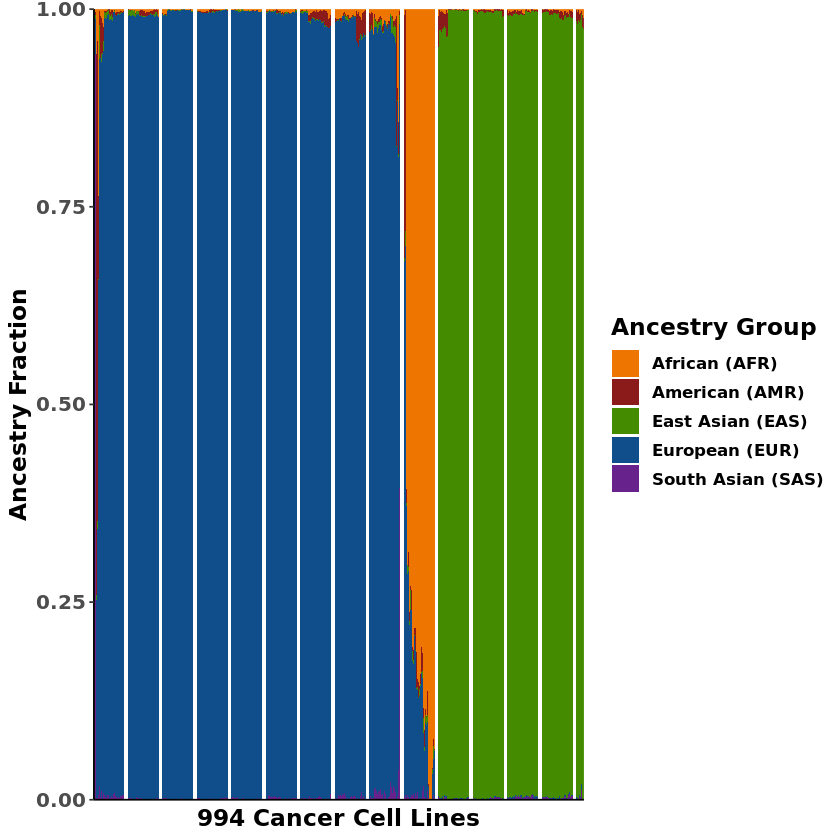

In [127]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Plot the data
rfmix.data.clustered %>%
melt() %>%
ggplot(aes(as.factor(sample), value, fill = variable)) + 
geom_col() +

scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text.x = element_blank(),
axis.ticks.x = element_blank()
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +

ylab("Ancestry Fraction") +
xlab("994 Cancer Cell Lines") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0))



#Export it to the google bucket
ggsave("ancestryplot.pdf")
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
gsutil cp ancestryplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


Calculate the fraction of cell lines that are significantly admixed. This is defined as having a minor ancestry frequency greater than 0.2.

In [10]:
#Calculate the minor ancestry fraction
minor.ancestry.fraction = rfmix.data %>%
select(-sample) %>%
rename("AFR" = 1, "AMR" = 2, "EAS" = 3, "EUR" = 4, "SAS" = 5) %>%
apply(1, max)

#Calculate the number of cell lines that are mostly one ancestry
mostly.single.ancestry = minor.ancestry.fraction[minor.ancestry.fraction >= 0.8] %>% length()
mostly.single.ancestry

#Calculate the number of cell lines that are significantly admixed
number.of.admixed.lines = nrow(rfmix.data) - mostly.single.ancestry
number.of.admixed.lines

#Calculate the fraction of cell lines that are significantly admixed
fraction.admixed = number.of.admixed.lines/(mostly.single.ancestry + number.of.admixed.lines)
fraction.admixed

[1] 952

[1] 42

[1] 0.04225352

Calculate the fraction of cell lines that are either mostly European or East Asian

In [16]:
#Calculate the number of cell lines that are east asian or european
num.eas.or.eur = rfmix.data %>%
select(-sample) %>%
rename("AFR" = 1, "AMR" = 2, "EAS" = 3, "EUR" = 4, "SAS" = 5) %>%
filter(EAS >= 0.8 | EUR >= 0.8) %>%
nrow(.)
fraction.eas.or.eur = num.eas.or.eur/nrow(rfmix.data)
fraction.eas.or.eur

#Calculate the fraction of cell lines that are european
fraction.european = rfmix.data %>%
select(-sample) %>%
rename("AFR" = 1, "AMR" = 2, "EAS" = 3, "EUR" = 4, "SAS" = 5) %>%
filter(EUR >= 0.8) %>%
nrow(.)
fraction.european = fraction.european/nrow(rfmix.data)
fraction.european

#Calculate the fraction of cell lines that are east asian
fraction.eas = rfmix.data %>%
select(-sample) %>%
rename("AFR" = 1, "AMR" = 2, "EAS" = 3, "EUR" = 4, "SAS" = 5) %>%
filter(EAS >= 0.8) %>%
nrow(.)
fraction.eas = fraction.eas/nrow(rfmix.data)
fraction.eas

[1] 0.9124748

[1] 0.610664

[1] 0.3018109

Create a better version of the ancestry plot which splits samples into major ancestry group

Using sample, ancestry_group as id variables

Saving 6.67 x 4 in image



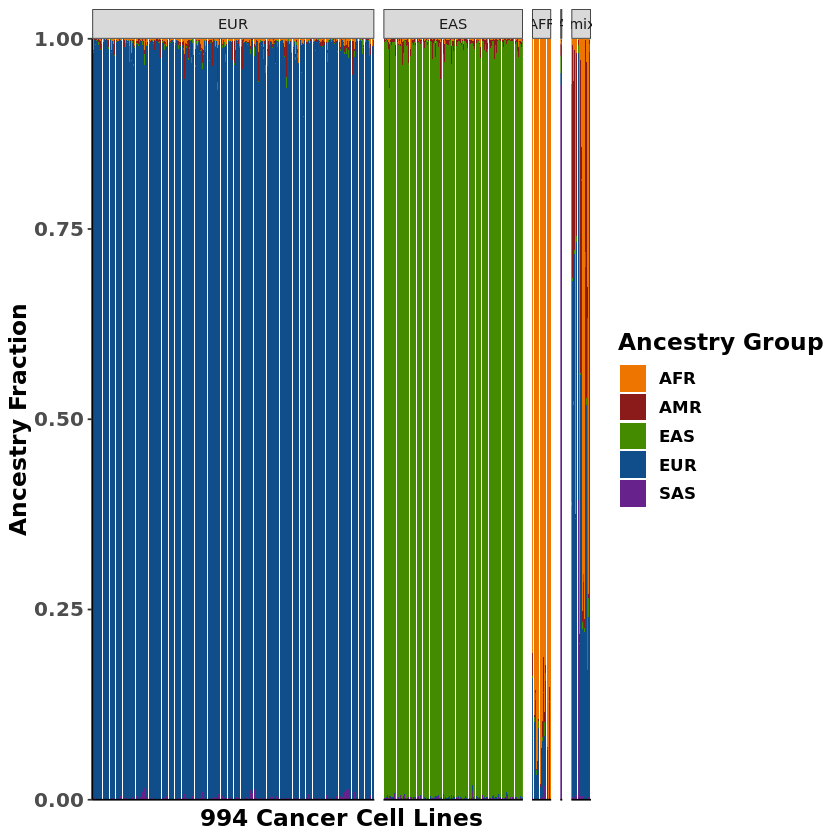

In [45]:
#Create the color vector
group.colors <- c("darkorange2", "firebrick4", "chartreuse4", "dodgerblue4", "darkorchid4")

#Plot the data
rfmix.data %>%
rename("AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
mutate(ancestry_group = ifelse(AMR >= 0.8, "AMR", 
                        ifelse(AFR >= 0.8, "AFR",
                        ifelse(EAS >= 0.8, "EAS",
                        ifelse(EUR >= 0.8, "EUR",
                        ifelse(SAS >= 0.8, "SAS", "Admixed")))))) %>%
melt() %>%
mutate(ancestry_group = factor(ancestry_group, levels = c("EUR", "EAS", "AFR", "SAS", "AMR", "Admixed"))) %>%
ggplot(aes(as.factor(sample), value, fill = variable)) + 
geom_col() +
facet_grid(. ~ ancestry_group, scales = "free", space = "free_x") +


scale_fill_manual(values = group.colors) +

theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text.x = element_blank(),
axis.ticks.x = element_blank()
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
  ) +

ylab("Ancestry Fraction") +
xlab("994 Cancer Cell Lines") +
labs(fill='Ancestry Group') +
scale_y_continuous(expand = c(0,0))


#Export it to the google bucket
ggsave("grouped_ancestryplot.pdf", height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
gsutil cp grouped_ancestryplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Calculate the number of cell lines that belong to each ancestry group

In [50]:
#Assemble the dataset
df.for.counting = rfmix.data %>%
rename("AFR" = 2, "AMR" = 3, "EAS" = 4, "EUR" = 5, "SAS" = 6) %>%
mutate(ancestry_group = ifelse(AMR >= 0.8, "AMR", 
                        ifelse(AFR >= 0.8, "AFR",
                        ifelse(EAS >= 0.8, "EAS",
                        ifelse(EUR >= 0.8, "EUR",
                        ifelse(SAS >= 0.8, "SAS", "Admixed"))))))


#Now count the number of cell lines
num.afr = df.for.counting %>% filter(ancestry_group %in% "AFR") %>% pull(sample) %>% unique() %>% length() #AFR
num.amr = df.for.counting %>% filter(ancestry_group %in% "AMR") %>% pull(sample) %>% unique() %>% length() #AMR
num.eas = df.for.counting %>% filter(ancestry_group %in% "EAS") %>% pull(sample) %>% unique() %>% length() #EAS
num.eur = df.for.counting %>% filter(ancestry_group %in% "EUR") %>% pull(sample) %>% unique() %>% length() #EUR
num.sas = df.for.counting %>% filter(ancestry_group %in% "SAS") %>% pull(sample) %>% unique() %>% length() #SAS
num.adm = df.for.counting %>% filter(ancestry_group %in% "Admixed") %>% pull(sample) %>% unique() %>% length() #admixed
num.lines = df.for.counting %>% pull(sample) %>% length()



#Calculate the fractions
fraction.afr = num.afr/num.lines
fraction.amr = num.amr/num.lines
fraction.eas = num.eas/num.lines
fraction.eur = num.eur/num.lines
fraction.sas = num.sas/num.lines
fraction.adm = num.adm/num.lines

#Print the results
paste("There are ", num.afr, " African cell lines. This is", fraction.afr*100, "% of the dataset") %>% print()
paste("There are ", num.amr, " American cell lines. This is", fraction.amr*100, "% of the dataset") %>% print()
paste("There are ", num.eas, " East Asian cell lines. This is", fraction.eas*100, "% of the dataset") %>% print()
paste("There are ", num.eur, " European cell lines. This is", fraction.eur*100, "% of the dataset") %>% print()
paste("There are ", num.sas, " South Asian cell lines. This is", fraction.sas*100, "% of the dataset") %>% print()
paste("There are ", num.adm, " Admixed cell lines. This is", fraction.adm*100, "% of the dataset") %>% print()


[1] "There are  41  African cell lines. This is 4.12474849094567 % of the dataset"
[1] "There are  0  American cell lines. This is 0 % of the dataset"
[1] "There are  300  East Asian cell lines. This is 30.1810865191147 % of the dataset"
[1] "There are  607  European cell lines. This is 61.066398390342 % of the dataset"
[1] "There are  4  South Asian cell lines. This is 0.402414486921529 % of the dataset"
[1] "There are  42  Admixed cell lines. This is 4.22535211267606 % of the dataset"


# Take a closer look at the ancestry fractions so that I can put some numbers into the paper text

In [23]:
rfmix.data %>% 
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
arrange(-afr) %>%
head()

#Calculate the average African ancestry fraction for all African cell lines
rfmix.data %>% 
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
filter(afr > 0.8) %>%
pull(afr) %>%
mean()

#Calculate the average European ancestry fraction for all European cell lines
rfmix.data %>% 
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
filter(eur > 0.8) %>%
pull(eur) %>%
mean()

#Calculate the average European ancestry fraction for all European cell lines
rfmix.data %>% 
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
filter(eas > 0.8) %>%
pull(eas) %>%
mean()

#For admixed cell lines, calculate the average American ancestry across all cell lines
rfmix.data %>%
rename("afr" = 2, "amr" = 3, "eas" = 4, "eur" = 5, "sas" = 6) %>%
filter(amr < 0.8) %>%
filter(afr < 0.8) %>%
filter(eas < 0.8) %>%
filter(eur < 0.8) %>%
filter(sas < 0.8) %>%
pull(amr) %>%
mean()



,sample,afr,amr,eas,eur,sas
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000654,1.0000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,ACH-000707,0.9993091,0.0000000000,0.0000000000,0.0006909091,0.0000000000
3,ACH-001318,0.9991477,0.0005959091,0.0000000000,0.0000000000,0.0002563636
4,ACH-001318.1,0.9991477,0.0005959091,0.0000000000,0.0000000000,0.0002563636
5,ACH-001064,0.9987423,0.0002563636,0.0003309091,0.0006700000,0.0000000000
6,ACH-000877,0.9985082,0.0002563636,0.0000000000,0.0009209091,0.0003145455


[1] 0.8925417

[1] 0.9856414

[1] 0.9887221

[1] 0.1629117

In [5]:
head(rfmix.data)

,sample,African (AFR),American (AMR),East Asian (EAS),European (EUR),South Asian (SAS)
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000657,0.9601677273,0.0005504545,0.0063213636,0.03192409,0.0010363636
2,ACH-000617,0.0028859091,0.0204050000,0.0000000000,0.97557545,0.0011336364
3,ACH-000685,0.8539895455,0.0272740909,0.0395313636,0.07403591,0.0051686364
4,ACH-000632,0.0025995455,0.0009922727,0.0001513636,0.99553364,0.0007231818
5,ACH-000171,0.0007454545,0.0000000000,0.0010822727,0.99686682,0.0013054545
6,ACH-000863,0.0065409091,0.0000000000,0.0036922727,0.96728000,0.0224868182
